In [284]:
from hmmlearn import hmm
import numpy as np
import pandas as pd
import os
import re
import json
from functools import reduce
import matplotlib.pyplot as plt


In [138]:
X1 = [[0.5], [1.0], [-1.0], [0.42], [0.24]]
X2 = [[2.4], [4.2], [0.5], [-0.24]]

X = np.concatenate([X1, X2])

lengths = [len(X1), len(X2)]
print(X)

model = hmm.GaussianHMM(n_components=3).fit(X, lengths)
model.sample(5)

Fitting a model with 14 free scalar parameters with only 9 data points will result in a degenerate solution.


[[ 0.5 ]
 [ 1.  ]
 [-1.  ]
 [ 0.42]
 [ 0.24]
 [ 2.4 ]
 [ 4.2 ]
 [ 0.5 ]
 [-0.24]]


(array([[ 0.57187568],
        [-0.35301602],
        [ 0.43188818],
        [-0.11532635],
        [ 0.46451172]]),
 array([2, 0, 2, 0, 0]))

# Winning conditions

Getting the best results for each level

- Stage 1. => how fast did the person finish
- Stage 2. => how far did they get

In [480]:
directory = '../DATA/BIRAFFE2/BIRAFFE2-games/'

LEVEL_1 = []
LEVEL_2 = []
LEVEL_3 = []

lvl1_deaths = []
lvl2_deaths = []

def get_time(json):
    data = json['timestamp']
    time_delta = (data.tail(1).values - data.head(1).values)/ np.timedelta64(1, 's')
    return time_delta[0]

def get_distance(json):
    data_x = json['x']
    data_y = json['y']    
    distance_x = data_x.tail(1).values[0] - data_x.head(1).values[0]
    distance_y = data_y.tail(1).values[0] - data_y.head(1).values[0]
    distance = np.sqrt(distance_x*distance_x + distance_y*distance_y)
    return distance

def get_deaths(json):
    deaths = max(json['deathCount'])
    return deaths

for subject_directory in os.listdir(directory):
    if os.path.isdir(directory+subject_directory):
        for filelogs in os.listdir(directory+subject_directory):
            if filelogs.find('-Level01_Log') != -1:
                name = directory+subject_directory+"/"+filelogs
                level_1 = pd.read_json(name)
                time = get_time(level_1)
                LEVEL_1.append([time])
                lvl1_deaths.append(get_deaths(level_1))
            if filelogs.find('-Level02_Log') != -1:
                name = directory+subject_directory+"/"+filelogs
                level_2 = pd.read_json(name)
                distance = get_distance(level_2)
                LEVEL_2.append([distance])
                lvl2_deaths.append(get_deaths(level_2))

In [159]:
LEVEL_1[0]

array([156.515])

In [160]:
LEVEL_2[0]

array([82.64206483])

In [150]:
LEVEL_1 = np.asarray(LEVEL_1).reshape(-1, 1)
lengths = np.ones(LEVEL_1.shape[0], dtype=int)
model_1 = hmm.GaussianHMM(n_components=3).fit(LEVEL_1, lengths)
model_1

Some rows of transmat_ have zero sum because no transition from the state was ever observed.


GaussianHMM(n_components=3)

In [151]:
LEVEL_2 = np.asarray(LEVEL_2).reshape(-1, 1)
lengths = np.ones(LEVEL_2.shape[0], dtype=int)
model_2 = hmm.GaussianHMM(n_components=3).fit(LEVEL_2, lengths)
model_2

Some rows of transmat_ have zero sum because no transition from the state was ever observed.


GaussianHMM(n_components=3)

In [153]:
model_1.transmat_

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [154]:
model_2.transmat_

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

# Events 
So the winning conditions didnt give the best results, changing that to amount of events in game.

In [323]:
LEVEL_1_EVENTS = ['deathCount', 'shootsCounter', 'hitCounter', 'collectedMoney', 
                  'collectedHealth', 'health', 'money', 'idOfSound']
LEVEL_2_EVENTS = ['deathCount', 'distortionLevel', 'pitchLevel', 'idOfSound']

level_1_event_logs = []
level_2_event_logs = []

def log_diffs(e1, e2, event_types):
    for i in event_types:
        if e1[i] != e2[i]:
            return i
    return None

def filter_logs(raw_json, event_types):
    filtered_logs = [raw_json[0]]
    for previous, current in zip(raw_json, raw_json[1:]):
        diff = log_diffs(current, filtered_logs[-1], event_types)
        if diff is not None:
            previous['event'] = diff
            filtered_logs.append(previous)

    filtered_logs[0]['event'] = 'start'
    last_log = raw_json[-1]
    last_log['event'] = 'complete'
    filtered_logs.append(last_log)

    return filtered_logs

for subject_directory in os.listdir(directory):
    if os.path.isdir(directory+subject_directory):
        try:
            with open(directory+subject_directory+'/'+subject_directory+'-Level01_Log.json') as file_json:
                level_1_event_logs.append(filter_logs(json.loads(file_json.read()), LEVEL_1_EVENTS))
            with open(directory+subject_directory+'/'+subject_directory+'-Level02_Log.json') as file_json:
                level_2_event_logs.append(filter_logs(json.loads(file_json.read()), LEVEL_2_EVENTS))
        except:
            continue

In [216]:
def get_event_coordinates(events, stage_list):
    x = events['x']
    y = events['y']
    return x,y
    
def get_coordinates_by_event_type(stage_list, event_type):
    coordinates = [get_event_coordinates(events, stage_list) for person in stage_list for events in person if events['event'] == event_type]
    return coordinates

In [449]:
def read_map(map_dir):
    with open(map_dir) as map_json:
        coordinates = [(coord['x'], coord['y']) for coord in json.loads(map_json.read())]
    return coordinates

def draw_map(map_coords):
    plt.scatter([x[0] for x in map_coords], [y[1] for y in map_coords], marker='s', c='black')

In [464]:
first_stage_map = read_map(directory+'Level01_StaticMap.json')
second_stage_map = read_map(directory+'Level02_StaticMap.json')

def draw_events_coordinates(event_coordinates, color):
    plt.scatter([x[0] for x in event_coordinates], [y[1] for y in event_coordinates], s=1, c=color)

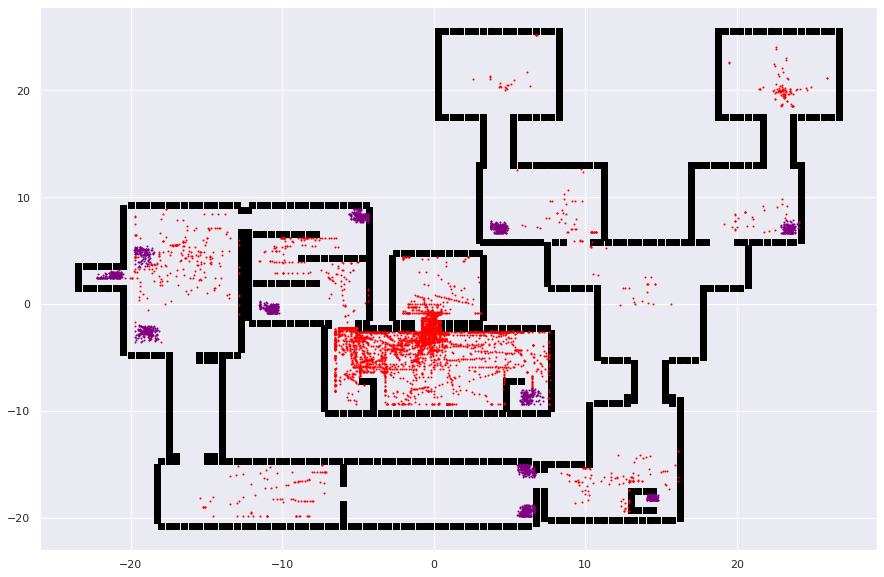

In [465]:
health_coordinates = get_coordinates_by_event_type(level_1_event_logs, 'health')
collectible_health_coordinates = get_coordinates_by_event_type(level_1_event_logs, 'collectedHealth')

plt.figure(figsize=(15,10))
draw_map(first_stage_map)
draw_events_coordinates(health_coordinates, 'red')
draw_events_coordinates(collectible_health_coordinates, 'purple')

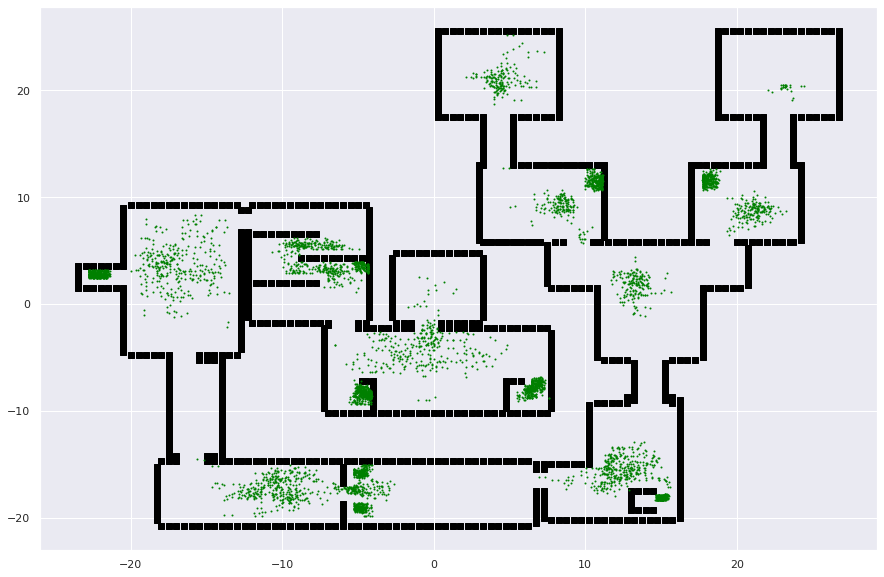

In [413]:
money_coordinates = get_coordinates_by_event_type(level_1_event_logs, 'collectedMoney')

plt.figure(figsize=(15,10))
draw_map(first_stage_map)
draw_events_coordinates(money_coordinates, 'green')

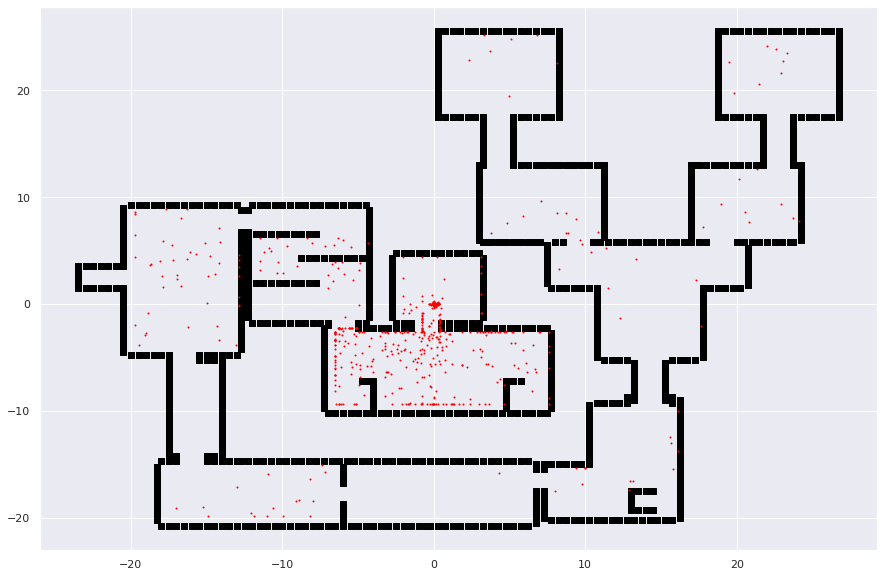

In [414]:
deaths_1_coordinates = get_coordinates_by_event_type(level_1_event_logs, 'deathCount')

plt.figure(figsize=(15,10))
draw_map(first_stage_map)
draw_events_coordinates(deaths_1_coordinates, 'red')

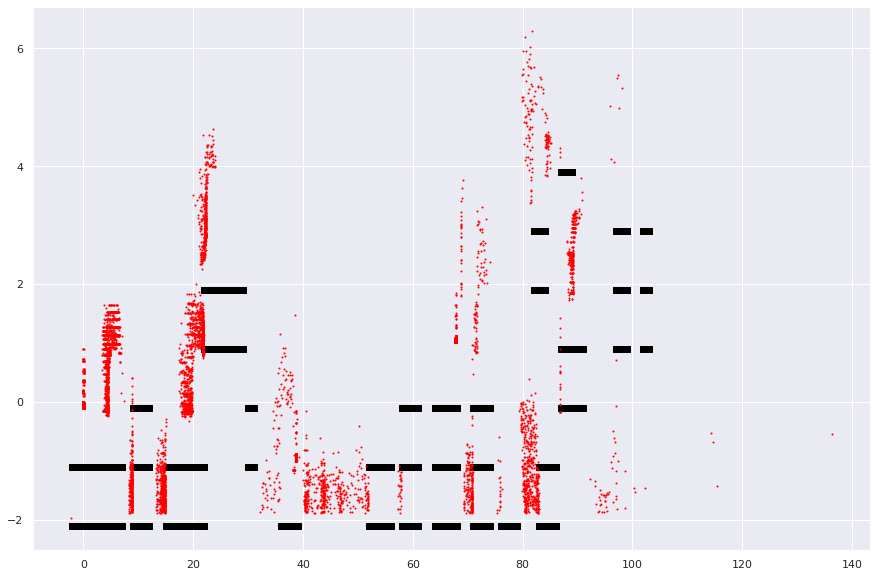

In [450]:
deaths_2_coordinates = get_coordinates_by_event_type(level_2_event_logs, 'deathCount')

plt.figure(figsize=(15,10))
draw_map(second_stage_map)
draw_events_coordinates(deaths_2_coordinates, 'red')

In [486]:
print("Summarized amount od deaths in stage 1.: ", sum(lvl1_deaths))
print("Summarized amount od deaths in stage 2.: ", sum(lvl2_deaths))

Summarized amount od deaths in stage 1.:  512
Summarized amount od deaths in stage 2.:  7197


In [487]:
max(lvl1_deaths)

20

In [488]:
max(lvl2_deaths)

163